# Homework 3 | Dimensionality Reduction & Surrogate Modelling 💼
4.453x Creative Machine Learning for Design<br/>
*Renaud Danhaive, Ous Abou Ras, Natasha Hirt, Caitlin Mueller*
<br/><br/>

---
👋 Welcome to the third assignment of 4.453x!! 👋

💡 In this assignment, **you will learn how to**:

- Implementing t-SNE and PCA from `sklearn`.
- Visualizing a 2216-dimensional vector of a sound fingerprint on a 2D plot by using dimensionality reduction techniques.
- Create an interactive 2D plot to explore the data.
- Create a Random Forest surrogote model
- Evaluate our surrogate model against a baseline
- Explore different datasets with different tools.

<br/><br/>

❗❗❗ The deliverable for this homework is a *viewable* link to your completed notebook AND a *viewable* link to your solution for the [MCQ](https://drive.google.com/file/d/1LF9-s-EzWhoDMQ9zgWkRaABUfsLMUWbB/view?usp=sharing). *It is your responsibility to rerun your notebook and make sure everything is running before submitting.*

❗❗❗ For questions that require you to submit a textual or visual answer, please collect your results in a separate Google Docs file to be shared at the end of the notebook.
For questions that request numerical results, you may simply print them with your code.

🤖 <font size="-1">At the risk of sounding like a broken record, we encourage you to practice good coding hygiene. This will help you write better code faster.
Remember:
- Explicit is better than implicit when naming objects. For example, a variable pointing to an array of dog images is better named as `dog_images_array` than as `d_array`.
- Don't repeat yourself (DRY). If you find yourself copy-pasting code, it's a good sign you should put that code in a function.
- Try to produce code that could almost be read as a sentence by somebody with some knowledge of what the code is trying to accomplish.
- More readable code is (almost always) better code. </font>

---

# **A. Creating a map of sounds with t-SNE**

In this section, we use the scikit-learn implementation of t-SNE (t-distributed stochastic neighbor embedding) to visualize a dataset of sounds.

The dataset was produced by extracting raw audio files from the Freesound Dataset 50k (FSD50K) dataset that were associated with CC0 or CC BY 3.0 licenses (allowing us to share this with you). Attributions for each audio file is contained in a metadata file we provide as well. These raw audio files were then cropped to 250ms and sampled at a rate of 48000 Hz resulting in 12,000-long sound waves. These waves were then "fingerprinted" using the same approach taken by Manny Tan, Kyle McDonald, and Yotam Mann for Google's [Infinite Drum Machine](https://github.com/googlecreativelab/aiexperiments-drum-machine).

Fingeprinting here refers to the process of decomposing the wave into sinusoidal waves and recording their intensities across time. As a result, for each raw audio file, we get a heatmap where the x-axis represents time, the y-axis represents frequency, and the recorded values represents the intensity of a given frequency at a given time. 

In this notebook, we use these fingerprints as input features to embed the high-dimensional audio files to a 2D space using t-SNE. Because fingerprints are essentially images, this process is similar to what we did for MNIST.

In addition to processing the audio files into their spectral fingerprints, we kept track of the raw audio files and their metadata in a csv file linking the indices of the fingerprints to the attributes of the raw file. This will allow us to build an interactive visualization taking advantage of the t-SNE embedding.

## **0.0 | Setup 🚧**

---

### 0.1 | Downloading files from a shared Google Drive link

In [ ]:
!pip install --upgrade --no-cache-dir gdown >/dev/null

In [ ]:
import gdown

gdown.download("https://drive.google.com/file/d/11PYigyH6qNQkLB_759sK_KJr1yxcHEwP/view?usp=sharing", fuzzy=True)
gdown.download("https://drive.google.com/file/d/11TYGj-1R7XN2avniNPZKYoNHRSOAaZ6K/view?usp=sharing", fuzzy=True)
gdown.download("https://drive.google.com/file/d/11T788o0xyu0Zs_oFAwoW2few584G22Fe/view?usp=sharing", fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=11PYigyH6qNQkLB_759sK_KJr1yxcHEwP
To: /content/fingerprints.npy
100%|██████████| 137M/137M [00:02<00:00, 45.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=11TYGj-1R7XN2avniNPZKYoNHRSOAaZ6K
To: /content/metadata.csv
100%|██████████| 6.85M/6.85M [00:00<00:00, 82.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=11T788o0xyu0Zs_oFAwoW2few584G22Fe
To: /content/trimmed_wav_files.zip
100%|██████████| 312M/312M [00:03<00:00, 90.3MB/s]


'trimmed_wav_files.zip'

### 0.2 | Unzipping sound files

In [ ]:
!unzip /content/trimmed_wav_files.zip >/dev/null

### 0.3 | Imports

In [ ]:
import numpy as np
from IPython.display import Audio
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import plotly.io as pio
import plotly.graph_objects as go

### 0.4 | Styling

In [ ]:
import google

is_dark = google.colab.output.eval_js(
    'document.documentElement.matches("[theme=dark]")'
)

matplotlib.rcParams["figure.dpi"] = 100
plt.rcParams["hatch.color"] = "white"

if is_dark:
    # load style sheet for matplotlib, a plotting library we use for 2D visualizations
    plt.style.use(
        "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
    )
    plt.style.use("dark_background")
    plt.rcParams.update(
        {
            "figure.facecolor": (0.22, 0.22, 0.22, 1.0),
            "axes.facecolor": (0.22, 0.22, 0.22, 1.0),
            "savefig.facecolor": (0.22, 0.22, 0.22, 1.0),
            "grid.color": (0.4, 0.4, 0.4, 1.0),
        }
    )
    plotly_template = pio.templates["plotly_dark"]
    pio.templates["draft"] = go.layout.Template(
        layout=dict(
            plot_bgcolor="rgba(56,56,56,0)",
            paper_bgcolor="rgba(56,56,56,0)",
        )
    )
    pio.templates.default = "plotly_dark+draft"
    
else:
    plt.style.use(
        "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
    )

plt.set_cmap("plasma");

<Figure size 600x400 with 0 Axes>

## **1.0 | Load and explore the dataset** 🕵️‍♀️

It's always good to take a look at what you're dealing with before doing anything else. In our case, let's load the array of fingerprints (i.e. the array of images) and the metadata.

---

### 1.1 | Loading the dataset

In [ ]:
# Getting the soundwave filenames to use later on
path = "/content/"
raw_audio_path = path + "trimmed_wav_files/"
convert_index_to_filename = lambda x: raw_audio_path + str(x) + ".wav"

# Loading the fingerprints of the sound wave
fingerprints = np.load(path + "fingerprints.npy")

# Loading the csv file in pandas to inspect the dataset
metadata = pd.read_csv(path + "metadata.csv")

### 1.2 | Printing first 5 rows of the dataset

In [ ]:
metadata.head(5)

,Unnamed: 0,index,tags,title,description,license,uploader
0,0,268259,"['guitar', 'sample', 'electric', 'funk', 'rock']",Funky Electric Guitar Sample 6 - 90 BPM,Recorded with Gibson Les Paul using P90 pickup...,http://creativecommons.org/publicdomain/zero/1.0/,bergice
1,1,40523,"['electric', 'guitar']",gui (2).wav,"electric guitar certainly not the best sample,...",http://creativecommons.org/licenses/by/3.0/,hubertmichel
2,2,40525,"['electric', 'guitar']",gui (4).wav,"electric guitar certainly not the best sample,...",http://creativecommons.org/licenses/by/3.0/,hubertmichel
3,3,5318,"['bass', 'electric', 'guitar', 'multisample']",dynaA#3.wav,Recorded direct with a Peavey Dynabass in pass...,http://creativecommons.org/licenses/by/3.0/,NoiseCollector
4,4,4258,"['distortion', 'dive', 'electric', 'free', 'gu...",Adive.wav,12th fret notes from each string with tremolo ...,http://creativecommons.org/licenses/by/3.0/,NoiseCollector


In [ ]:
print(fingerprints.shape)

(16209, 46, 46)


### 1.3 | Plotting a sample

We see we have a little over 16k samples in this pre-processed dataset.
Let's show what a random fingerprint looks like.


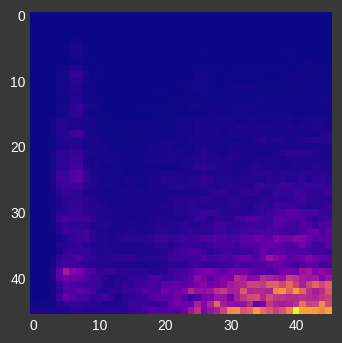

In [ ]:
sample_num = np.random.randint(fingerprints.shape[0])
sample_print = fingerprints[sample_num]
plt.imshow(sample_print, cmap="plasma")
plt.grid(None)

### 1.4 | Playing the sound of that sample
We can query the samples corresponding metadata to play the audio.


In [ ]:
sample_metadata = metadata.iloc[sample_num]
print(sample_metadata)
sample_file = convert_index_to_filename(sample_metadata["index"])
Audio(sample_file)

Unnamed: 0                                                  1517
index                                                     120180
tags           ['chair', 'dragging', 'floor', 'furniture', 's...
title                                        chaise_glisse11.wav
description       dragging a wood chair on a tiled kitchen floor
license              http://creativecommons.org/licenses/by/3.0/
uploader                                            MaxDemianAGL
Name: 1517, dtype: object


### 1.5 | Plot a 10 by 20 grid of fingerprints

Plotting a gallery of selected fingerprints to get a glimpse of what we are up against as far as data diversity.


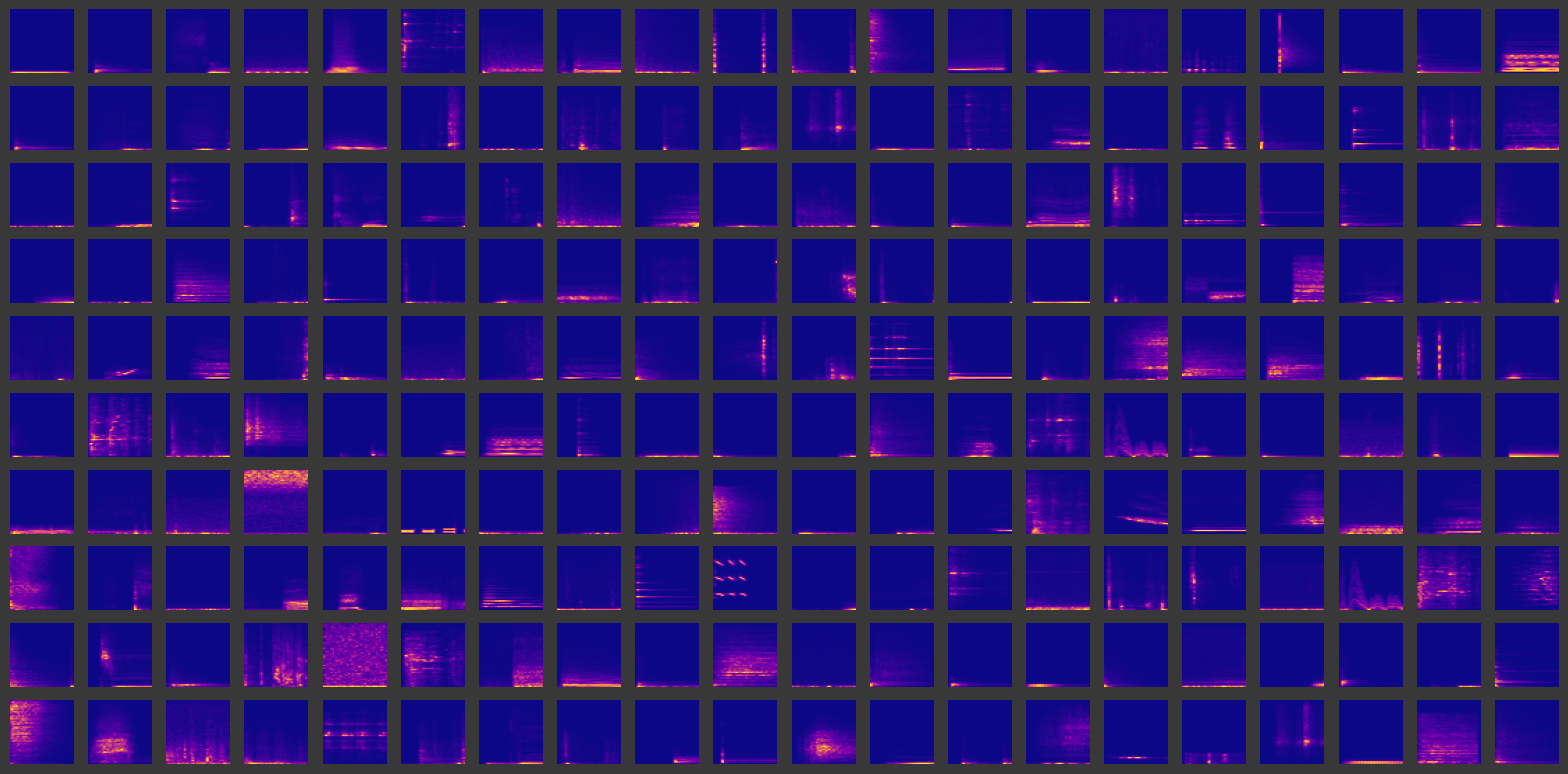

In [ ]:
n_samples = fingerprints.shape[0]

fig, axes = plt.subplots(10, 20, figsize=(20, 10))
for row in axes:
    for col in row:
        i = np.random.randint(n_samples)
        fingerprint = fingerprints[i]
        col.imshow(fingerprint)
        col.axis("off")
        n_samples = fingerprints.shape[0]

## **2.0 | Embed fingerprints using t-SNE**
Now that we're a little familiar with the data. Let's actually build the embedding. 

---

### 2.1 ❓ Flatten the images [0.5]

The t-SNE expects a list of 1D vectors.

*Hint: Print the shape of your list of vectors to make sure it makes sense*

In [ ]:
flat_fingerprints = fingerprints.reshape((16209, -1))
print (flat_fingerprints.shape)

(16209, 2116)


<font color='LightGray'>
Each data point is now a 2216-dimensional vector. In other words, we'll project data living in a 2116-dimensional space to 3- and 2-dimensional ones! </br>
Let's start with 3D embeddings!
</font>


### 2.2 ❓ Project the fingerprint into 3D space using t-SNE [1.0]

We can be pretty liberal when picking the `perplexity` value. Any value between 20-100 will probably do the trick. 
</br>This step will take a while as the dataset is huge. ⏳⏳⏳


In [ ]:
embedding_3d = TSNE(
    n_components=3, perplexity=30, verbose=1, n_iter=1000
).fit_transform(flat_fingerprints)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16209 samples in 0.014s...
[t-SNE] Computed neighbors for 16209 samples in 36.499s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16209
[t-SNE] Computed conditional probabilities for sample 2000 / 16209
[t-SNE] Computed conditional probabilities for sample 3000 / 16209
[t-SNE] Computed conditional probabilities for sample 4000 / 16209
[t-SNE] Computed conditional probabilities for sample 5000 / 16209
[t-SNE] Computed conditional probabilities for sample 6000 / 16209
[t-SNE] Computed conditional probabilities for sample 7000 / 16209
[t-SNE] Computed conditional probabilities for sample 8000 / 16209
[t-SNE] Computed conditional probabilities for sample 9000 / 16209
[t-SNE] Computed conditional probabilities for sample 10000 / 16209
[t-SNE] Computed conditional probabilities for sample 11000 / 16209
[t-SNE] Computed conditional probabilities for sample 12000 / 16209
[t-SNE] Computed conditional probabilities for sa

### 2.3 | Convert the point coordinates into colors

We could plot this embedding in 3d, and it would look cool. But it would also be quite hard to navigate because of occlusion issues. It turns out 3D data visualization is not always super intuitive!

So we're not going to plot the embedding points in 3d here (though that's a good exercise for you to do 😊), but let's convert the coordinates of the points into colors. We'll use these colors to add another layer of information in our 2d embedding.

In [ ]:
print(embedding_3d.shape)

(16209, 3)


In [ ]:
colors = (
 255*(embedding_3d - np.min(embedding_3d, axis=0))
    / (np.max(embedding_3d, axis=0) - np.min(embedding_3d, axis=0))
)

### 2.4 ❓ Project the fingerprints into a 100-dimensional space using PCA. [1.0]
Use `PCA` to project the flattened footprints into a 100-dimensional space.

In [ ]:
pca_embedding = PCA(n_components=100).fit_transform(flat_fingerprints)

### 2.5 ❓ Project the PCA embeddings to 2D embeddings using t-SNE. [1.0]

Project the resulting `pca_embedding` in a 2d space using t-SNE. Your final projected data (in the 2d space) should be assigned to a variable called embedding.

*Hint: the `init` argument in the `TSNE` function needs to be defined as `"pca"`*

In [ ]:
embedding = TSNE(
    n_components=2, init='pca', perplexity=30, verbose=1, n_iter=1000
).fit_transform(flat_fingerprints)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16209 samples in 0.015s...
[t-SNE] Computed neighbors for 16209 samples in 34.185s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16209
[t-SNE] Computed conditional probabilities for sample 2000 / 16209
[t-SNE] Computed conditional probabilities for sample 3000 / 16209
[t-SNE] Computed conditional probabilities for sample 4000 / 16209
[t-SNE] Computed conditional probabilities for sample 5000 / 16209
[t-SNE] Computed conditional probabilities for sample 6000 / 16209
[t-SNE] Computed conditional probabilities for sample 7000 / 16209
[t-SNE] Computed conditional probabilities for sample 8000 / 16209
[t-SNE] Computed conditional probabilities for sample 9000 / 16209
[t-SNE] Computed conditional probabilities for sample 10000 / 16209
[t-SNE] Computed conditional probabilities for sample 11000 / 16209
[t-SNE] Computed conditional probabilities for sample 12000 / 16209
[t-SNE] Computed conditional probabilities for sa

### 2.6 ❓ Plot the 2D embeddings [1.0]
Plot the 2d embedding and color the points according to the colors computed based on the 3d embedding like in Google's Infinite Drum Machine. Make sure to turn off the axis of the plot.
Remember the scale of the axes mean nothing so we remove them altogether. 


*Hint: You can use `plt.scatter` for plotting, and `plt.axis("off")` to turn off the axis of the plot.*

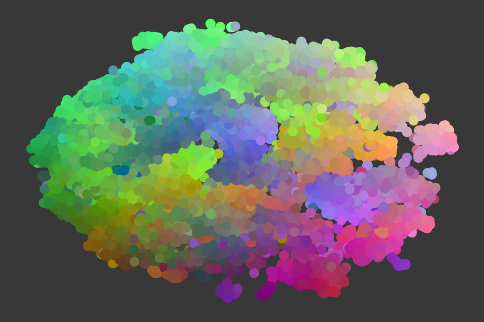

In [ ]:
plt.scatter(embedding[:,0], embedding[:,1], c=colors)
plt.axis('off')
plt.show()

## **3.0 | Interactive Visualization**
Ok, we have our embedding but it's hard to make anything of it since we can't listen to the data points or even read their associated sounds.

To do that, we'll recreate the visualization you just plotted above, but we'll make it interactive! Specifically, we'll make it such that when when hover over a point a circle will be drawn around to highlight the selected point. And when you click, it will plot the fingerprint of the selected sample as well as play its sound!

e could use our good old `plotly`, but because there are lots of data points to display, it would struggle performance-wise because it uses vector graphics. To address this issue, we'll use `ipycanvas`, a raster-based drawing library that supports some interactivity.

We are not asking you to code anything in this section, but we really encourage to read through the code and understand what is happening. You never know: some of this could be useful for your project!

---

### 3.1 | Install ipycanvas

In [ ]:
!pip install -q ipycanvas==0.11.0 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.8 MB/s eta 0:00:00


### 3.2 | Imports and setup

In [ ]:
from scipy.spatial import KDTree
from ipycanvas import hold_canvas, Canvas, MultiCanvas
import ipywidgets as widgets

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

### 3.3 | Rescale embedding to match canvas size

With ipycanvas, you are literally drawing the points, which means we have to get their coordinates first. We'll do that by rescaling the embedding to match the size of the canvas. We also build a so-called k-d tree (a type of search tree) using scipy. This will allow us to quickly query the closest point to where our mouse is located. The index of that point will then be used to retrieve its corresponding sound and fingerprint, which will be (dis)played on mouse click. We also use the k-d tree to highlight the closest point on hover.

In [ ]:
canvas_size = 1000
margin = 30
cloud_size = canvas_size - margin * 2

# rescale embedding to canvas pixel space
points_x = (embedding[:, 0] - np.min(embedding[:, 0])) / (
    np.max(embedding[:, 0]) - np.min(embedding[:, 0])
) * cloud_size + margin
points_y = (embedding[:, 1] - np.min(embedding[:, 1])) / (
    np.max(embedding[:, 1]) - np.min(embedding[:, 1])
) * cloud_size + margin

print(points_x.shape)
points_x = points_x[::20]
points_y = points_y[::20]
print(points_x.shape)
# build k-d search tree
kdtree = KDTree(np.array([points_x, points_y]).T)

(16209,)
(811,)


### 3.4 | Create a placeholder output
Let's create a placeholder output where we'll visualize the fingerprint of the played sounds. We'll also use it the play the sounds with the Audio widget.

In [ ]:
fingerprint_output = widgets.Output()

### 3.5 | Building our interactive canvas
Make sure to open a scratch cell (`Crtl+Alt+N` or `Insert>Scratch Code Cell`) where you simply run `fingerprint_output` to display the fingerprint and play the sound alongside your plot.

Let's actually build the visualization. We'll use a so-called multicanvas. One canvas will hold the static point cloud visualization and the other one will be used to draw the circular highlight on the closest point.

Note:
To plot each point with a different color, we need to draw them individually wiht ipycanvas. This worked fine when running this notebook locally on my computer, but colab seems to struggle with that. I commented out the code that draws the points with the colors computed with the 3d embedding, so you can check it out on your own system if you'd like to. Here, the points are drawn with the same color.

In [ ]:
canvas = MultiCanvas(2, width=canvas_size, height=canvas_size, sync_image_data=True)
canvas.layout.width = "1000px"
canvas.layout.height = "1000px"

html_colors = [
    "#{0:02x}{1:02x}{2:02x}".format(int(c[0]), int(c[1]), int(c[2])) for c in colors
]  # ipycanvas wants html colors

# The following lines do not work well on colab
with hold_canvas(canvas):  # hold sync of canvas for performance
    for i, (point_x, point_y, c) in enumerate(zip(points_x, points_y, html_colors)):
        canvas[0].fill_style = c
        canvas[0].fill_circle(str(point_x), str(point_y), 7)

hovered_point_index = None

# event on mouse hover
def handle_mouse_move(x, y):
    global hovered_point_index
    idx = kdtree.query([[x, y]])[1][0]
    if hovered_point_index != idx:
        hovered_point_index = idx
        canvas[1].clear()
        canvas[1].stroke_style = html_colors[hovered_point_index]
        canvas[1].line_width = 10
        canvas[1].stroke_circle(
            str(points_x[hovered_point_index]), str(points_y[hovered_point_index]), 40
        )


# event on mouse click
def handle_mouse_down(x, y):
    idx = kdtree.query([[x, y]])[1][0]
    file_index = metadata.iloc[idx, 1]
    file_name = convert_index_to_filename(file_index)
    with fingerprint_output:
        fingerprint_output.clear_output()
        print(f"File: {file_name}")
        print(f"Metadata: {metadata.iloc[idx]}")
        plt.imshow(fingerprints[idx])
        plt.grid(None)
        plt.show()
        display(Audio(file_name, autoplay=True))

# register event
canvas[1].on_mouse_move(handle_mouse_move)
canvas[1].on_mouse_down(handle_mouse_down)

display(canvas)

MultiCanvas(height=1000, layout=Layout(height='1000px', width='1000px'), sync_image_data=True, width=1000)

## **4.0 | Exploring the embeddings**

The following questions might require you to plot and use the interactive visualization we made above. 

If you've opened the scratch cell to display `fingerprint_output` alongside the plot, you should see the fingerprint corresponding to a sample you click and its sound should play automatically. Because the visualization is running on colab, it is not as smooth as if it were running locally (since each event must flow from you front-end to the virtual machine hosted by colab).

---

### 4.1 ❓ Find two sounds that are close to each other AND similar [1.0]
By interacting with the visualization, find a pair of sounds that sound similar (but are not duplicates) and are close to each other on the plot. Plot their fingerprints and display sound players for each sound.



In [ ]:
sample_metadata = metadata.iloc[320]
print(sample_metadata)
sample_file = convert_index_to_filename(sample_metadata["index"])
Audio(sample_file)

Unnamed: 0                                                   320
index                                                     423339
tags           ['silver', 'quarter', 'desk', 'currency', 'dro...
title                                           Silver Quarter 3
description                 Dropping a silver quarter on a desk.
license        http://creativecommons.org/publicdomain/zero/1.0/
uploader                                           greenvwbeetle
Name: 320, dtype: object


In [ ]:
sample_metadata = metadata.iloc[451]
print(sample_metadata)
sample_file = convert_index_to_filename(sample_metadata["index"])
Audio(sample_file)

Unnamed: 0                                                   451
index                                                     423333
tags           ['quarter', 'desk', 'currency', 'drop', 'money...
title                                             Clad Quarter 2
description                        Dropping a quarter on a desk.
license        http://creativecommons.org/publicdomain/zero/1.0/
uploader                                           greenvwbeetle
Name: 451, dtype: object


### 4.2 ❓ Find two sounds that are close to each other BUT different [1.0]

The embedding is not perfect, and it's likely not all of these sounds are mapped perfectly. By interacting with the visualization, find a pair of sounds that do **not** sound similar but are close to each other on the plot. Plot their fingerprints and display sound players for each sound.

In [ ]:
sample_metadata = metadata.iloc[807]
print(sample_metadata)
sample_file = convert_index_to_filename(sample_metadata["index"])
Audio(sample_file)

Unnamed: 0                                                   807
index                                                     233412
tags           ['water', 'percussion', 'splashing', 'splash',...
title                                               splash11.wav
description            Tossing rocks into a high mountain lake. 
license              http://creativecommons.org/licenses/by/3.0/
uploader                                               Rocktopus
Name: 807, dtype: object


In [ ]:
sample_metadata = metadata.iloc[767]
print(sample_metadata)
sample_file = convert_index_to_filename(sample_metadata["index"])
Audio(sample_file)

Unnamed: 0                                                   767
index                                                     212787
tags                       ['water', 'splash', 'aqua', 'liquid']
title                                                 Splash.mp3
description    A splashing Sound.\r\nRecorded with a Rode MS-...
license              http://creativecommons.org/licenses/by/3.0/
uploader                                                Mamboman
Name: 767, dtype: object


### 4.3 ❓ Pitch one way t-SNE could support design in your field of study.[1.0]
(100 words max)

In [ ]:
# I am currently working on digital fabrication projects. t-SNE can support support design in digital fabrication by helping designers optimize 
#the placement of individual components within a larger structure. By visualizing the relationships between the different components in a 
#low-dimensional space, designers could identify clusters of components that work well together, or that should be placed in close proximity 
#to one another for structural or aesthetic reasons. This could help designers optimize the use of materials, reduce waste, and improve the overall 
#strength and durability of the final product.

## **5.0 | BONUS - Organize your own images** [2.0]

This is a bonus question, so you DON'T have to do it - but if you do you'll get bonus points, and learn how to apply the techniques you learned on your own dataset. Leave it to the end if you have time.

The task is to organize images in your folder linearly (*must be more than 100 images*), so that images that look like are sorted closer to one another. Since this is an open question, we won't give you much guidance on how to implement the method. The steps below are just a few hints on how the algorithm can go, but you can implement it in other ways, so feel free to ignore them and make your own method. You could try PCA then t-SNE 1D, or t-SNE 10D to 2D to 1D. The Or you can even test a different algorithm alltogether! 
You may need to import/install other libraries.
<br></br>
*Note: We won't check your code, but you do have to write it down. However, if you want to get the bonus*, ***provide a screenshot of the first ~50+ images in your folder, before AND after they have been organized. You can screenshot your folder, or you can plot a gallery of the images, but in the order in which they have been organized.***

---

### 5.1 | Load your images
We recommend you resize your images to a lower resolution (maybe 64x64) so that the t-SNE works faster. It is also a good idea to plot the images in a grid to check that you loaded them correctly and inspect your dataset.

In [ ]:
# YOUR CODE HERE

### 5.2 | Find a 3D embedding of your dataset and map that to colors
We are basically redoing the first half of Part 2. Remember to flatten your dataset before using t-SNE!

In [ ]:
# YOUR CODE HERE

### 5.3 | Find a 1D embedding of your 3D embedding

In [ ]:
# YOUR CODE HERE

### 5.4 | Scatter the 1D embeddings on a line with corresponding 3D color embedding
This is to check if the 3D embedding have been stacked closer to one another in 1D space.

In [ ]:
# YOUR CODE HERE

### 5.5 | Sort images by name in a new folder
Copy images from the original folder to a new folder, and rename the images based on their order in the t-SNE 1D embedding. We recommend to use `shutil.copy()` 


In [ ]:
# YOUR CODE HERE

### All done with Section A!! 💪🎵
This part could have been longer, but the asbtractions in scikit-learn makes using some pretty complicated algorithms as easy as writing one line of code!

---

# **B. Surrogate Modelling - Midsole Part 2**

[In the notebook that we briefly covered in class](https://drive.google.com/file/d/1v3kCwaYB9MD8URqD6NJYFEwo9fN9FScc/view?usp=sharing), we built the 3d-printed lattice midsole design space and sampled a dataset of 3000 pairs of input density parameters/variables and output average frontfoot and rearfoot displacements. In this notebook, we'll inspect the data and train a random forest surrogate model to predict these values for any input density parameters.

Before completing this assignment, make sure you understand the broad strokes of the data generation notebook. You do not need to understand the code, but understanding the design space will help better contextualize this assignment. We encourage you to run the notebook and download and inspect the generated midsole meshes in an external tool (such as [MeshLab](https://www.meshlab.net/)). However, you do not need to run the sampling to completion (which would take hours) as we provide you with a previously sampled dataset.

Contrarily to the previous assignments, we almost solely provide setup code (imports and installations). To complete this assignment, we invite you to refer the two other notebooks we covered in class:
- [Notebook 1: regression on a toy dataset](https://drive.google.com/file/d/1xjQRgtlpl3FWIKgV_5jl-RwQMmaCu-dg/view?usp=sharing)
- [Notebook 2: PV potential example (regression + cross-validation)](https://drive.google.com/file/d/1o81eeAfhLXWWXfw6LmpwBPNgfCcEJ0Qj/view?usp=sharing)

## **0.0 | Setup 🚧**

---

#### 0.1 | Download sampled data

In [1]:
%%bash
rm -rf "/content/utils"
git clone https://github.com/danhaive/4.453x-resources.git
mv  -v "/content/4.453x-resources/04" "/content/utils"
rm -r "/content/4.453x-resources"

renamed '/content/4.453x-resources/04' -> '/content/utils'


Cloning into '4.453x-resources'...
Updating files: 100% (87/87), done.


#### 0.2 | Imports

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# plotly
import plotly.io as pio
import plotly.graph_objects as go

# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

## **1.0 | Brief data exploration**
In this section, you load the data sampled in the data generation notebook and inspect the dataset to understand a little better the regression you will try to solve. Brief (or more in-depth) data explorations are important to understand the scope of your problem and to diagnose whether there are obvious problems in your data. Because datasets like this one are synthetic, we're not expecting major surprises but we still recommend to carry out brief data explorations like this one prior to training a surrogate model.

---

### 1.1 | Load the data

The sampled dataset was downloaded to the runtime storage by code in the cells above. Load the data in a variable and print the keys contained in the dataset. 

Our dataset is a dictionary, which has keys and values represented as `key: value`. For example,  in `{"age": 24}`, `"age"` is a key and `24` is the corresponding value. The path of the data is hard-coded in the variable `path`.


In [3]:
path = "/content/utils/midsole_data/midsole_sampling_3000.npz"
data = np.load(path)

### 1.2 ❓ What do the different keys of the dataset correspond to? 
You may need to inspect the data generation notebook to answer this question.


In [7]:
print(data.files)

['samples', 'frontfoot_results', 'rearfoot_results']


### 1.3 ❓ Assign the sampled design variables

Assign the sampled design variables and their corresponding frontfoot results to two variables `samples` and `targets` (respectively).
We have collected a dataset with both frontfoot and rearfoot results, but we'll only focus on the frontfoot results. 

*Note: Frontfoot refers to the front portion of the midsole.*

In [10]:
samples = data['samples']
targets = data['frontfoot_results']

### 1.4 ❓ Compute some data stats

Compute and print (round to 1 decimal place) the *mean*, *standard deviation*, *10th percentile*, and *90th percentile* of the frontfoot displacements

In [12]:
mean =  round(np.mean(targets),1)
std = round(np.std(targets),1)
p10 = round(np.percentile(targets,10),1)
p90 = round(np.percentile(targets,90),1)

print("Mean frontfoot displacement:", mean)
print("Standard deviation of frontfoot displacement:", std)
print("10th percentile of frontfoot displacement:", p10)
print("90th percentile of frontfoot displacement:", p90)

Mean frontfoot displacement: 7.6
Standard deviation of frontfoot displacement: 2.0
10th percentile of frontfoot displacement: 5.0
90th percentile of frontfoot displacement: 10.2


Looks like the range of possible values is not that large. Let's visualize the distribution of the targets with a simple histogram.

By the way, one way to think about the standard deviation is to see it as the root mean squared error of the model (RMSE) that would predict the mean of the observations for any input parameters. So any model should perform a whole lot better than that to be worth anything.

### 1.5 ❓ Visualize the distribution of the targets
 Visualize the distribution of teh targets by plotting a histogram (use 20 bins)

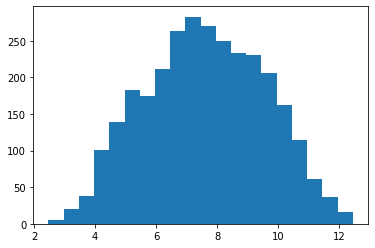

In [13]:
plt.hist(targets,bins = 20)
plt.show()

Looks like the distribution of observed displacements is normal-like.

Let's build a parallel coordinate plot to see how input densities relate to output displacement. We'll threshold the displacements to see if we can discern any pattern.

### 1.6 ❓ Visualize how input densities relate to the output displacement using a parallel coordinate plot.
Feel free to use any visualization package (though we recommend matplotlib or plotly). If you're using a static visualization, make sure to introduce a variable that you can modify to threshold the samples based on their targets. This will allow to inspect whether there is a clear relationship between input densities and output targets. If you use plotly, you can interactively filter the parallel coordinate plot.

In [15]:
n_dim = samples.shape[1]
parallel_plot_data = [
                      dict(
                          label=f"Density{i+1}", values=samples[:,i]
                           ) 
                      for i in range(n_dim)
                      ]
parallel_plot_data.append(
    dict(
        label="Frontfoot Displacement", values = targets
    )
)



In [16]:
parallel_coordinate_figure = go.Figure(data=
    go.Parcoords(
        line = dict(
            color = targets,
            colorscale="plasma",
            showscale=True,
            ),
        dimensions =parallel_plot_data
    )
)
parallel_coordinate_figure.show()

The parallel coordinate plot is not super instructive. There's clearly a relationship between density and output that is quite discernible for extreme displacement values (higher density = lower displacement and vice-versa), but that's something we'd expect.

## **2.0 Training a random forest model**
Enough playing around, let's train a random forest model. It'd be best to perhaps start with a linear model to establish a baseline model against which we can compare any more complex model, but we'll do that later if the random forest model is an obvious miss.

As in other notebooks, we'll use grid search with cross-validation to select good hyperparameters for our random forest. 

--- 



### 2.1 ❓ Split the dataset in training and testing sets
80% of the dataset should be used for training data. Make sure the data is shuffled when split.

The input features and targets for the training set should be respectively stored in `X_train` and `Y_train`.

The input features and targets for the testing set should be respectively stored in `X_test` and `Y_test`.

*Hint: Use scikit-learn's built-in function.*

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(samples, targets, test_size=0.2, random_state=42)
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (2400, 18)
Y_train shape: (2400,)
X_test shape: (600, 18)
Y_test shape: (600,)


### 2.2 | Define hyperparameter values to search to yield to best random forest model
We already defined the possible hyperparameters for you in the code below. We'll do a grid search over these hyperparameter values and use the model that yields the best cross-validation error.

In [18]:
hyperparams = {
    "n_estimators": [10, 20, 50, 100, 200],
    "max_features": [6, 12, 18],
    "max_depth": [2, 4, None],
}


### 2.3 ❓ Declare a random forest regressor called `random_forest_regressor`
No need for any argument as you are just declaring the base model whose hyperparameters will be changed during the grid search.

*Hint: Inspect the imports at the top of section B.*

In [19]:
random_forest_regressor = RandomForestRegressor()

### 2.4 ❓ Declare a cross-validated regressor called `cv_regressor`
Use scikitlearn abstraction for fitting multiple models and returning the best according to $k$-fold cross-validation.

Use 5 folds, negative mean squared error as the scoring method, the hyperparameters defined above for the grid search, and make sure the best model refits over the entire dataset after the search.

*Hint: You can achieve all of this by declaring an instance of a scikitlearn class.*

In [21]:
cv_regressor = GridSearchCV(estimator=random_forest_regressor,
                            param_grid=hyperparams,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            refit=True)

print(cv_regressor)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None], 'max_features': [6, 12, 18],
                         'n_estimators': [10, 20, 50, 100, 200]},
             scoring='neg_mean_squared_error')


### 2.5 ❓ Fit random forest models and retain the best one
Fit the cross-validated regressor. As you know, "fitting" here actually involves fitting multiple models to multiple sets, getting their cross-validation errors, and refitting the model with the score.

*Fitting the data might take a few minutes to compute.* ⌛

In [22]:
cv_regressor.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None], 'max_features': [6, 12, 18],
                         'n_estimators': [10, 20, 50, 100, 200]},
             scoring='neg_mean_squared_error')

### 2.6 ❓ Print the values of the best hyperparameters found


In [23]:
print('Best hyperparameters:', cv_regressor.best_params_)
print('Best score:', cv_regressor.best_score_)

Best hyperparameters: {'max_depth': None, 'max_features': 12, 'n_estimators': 200}
Best score: -0.6984451042899262


## **3.0 Evaluate model quality**

To evaluate the quality of our Random Forest Model, we will compare it to a baseline.

---

### 3.1 ❓ Compute the RMSE of the model against the test set
Compute the RMSE (root mean squared error) of the model predictions against the test set `Y_test`

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

Y_pred = cv_regressor.predict(X_test)
predicted_test = Y_pred
mse = mean_squared_error(Y_test, Y_pred)
rmse = sqrt(mse)

print("RMSE:", rmse)

RMSE: 0.8220078934252811


### 3.2 ❓ Compute the RMSE of the mean of the training set against the test set 

This is our baseline, we are basically computomg the RMSE if we predict the mean of the training set `Y_train` against our testing set `Y_test`.

In [33]:
mean_Y_train = Y_train.mean()

Y_pred_mean = [mean_Y_train] * len(Y_test)

mse_mean = mean_squared_error(Y_test, Y_pred_mean)
rmse_mean = sqrt(mse)

print('RMSE of mean of training set:', rmse_mean)

RMSE of mean of training set: 0.8220078934252811


### 3.3 ❓ How does the model compare to the mean baseline?
Print the RMSEs computed above (round to 2 decimal places) and write down a few words on how the model compares to the baseline.

In [34]:
print('RMSE of mean of training set:', round(rmse_mean, 2))
print('RMSE of random forest model:', round(rmse, 2))

"the random forest model performs much better than the mean baseline, with a much lower RMSE"

RMSE of mean of training set: 0.82
RMSE of random forest model: 0.82


'the random forest model performs much better than the mean baseline, with a much lower RMSE'

The RMSE for our cross-validated random forest looks decent. At least, it is a lot better than the RMSE with the mean (though that should never be a high bar to clear).

### 3.4 | Visualize the quality of the fit

Let's visualize the quality of predictions on the training and test sets. We're dealing with an 18-dimensional design space, so assessing the fit is not as straightforward as in 1-,2-, or 3-dimensional spaces. 

Nevertheless, one particularly effective way to assess the quality of the fit is to plot observed values against predicted values as a 2d scatter plot. If the predictions are perfect, all points in the figure will line up on the $y=x$ line. The further away the points are from this theoretical, the worse.

Below we produce exactly this visualization for the model trained above (on both the training and validation sets), which clearly shows how the model deviates from the exact analysis.

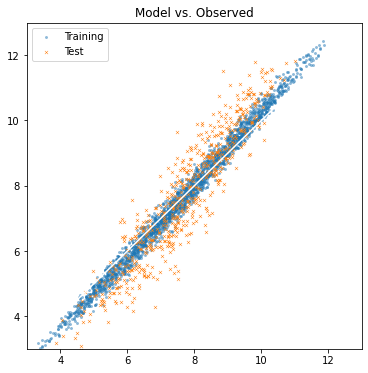

In [35]:
plt.figure(figsize=(6,6))
plt.title("Model vs. Observed")
plot_limits = [3,13]

plt.plot(plot_limits, plot_limits, "-", color="white")
plt.scatter(
    cv_regressor.predict(X_train),
    Y_train,
    s=5,
    linewidths=0.5,
    label="Training",
    alpha=0.5,
)
plt.scatter(
    predicted_test, Y_test, s=10, marker="x", linewidths=0.5, label="Test"
)
plt.legend()
plt.xlim(plot_limits)
plt.ylim(plot_limits)
plt.show()

Honestly, this is pretty good! Unsurprisingly, the fit is better for the training data, but it does not generalize too bad to the test set. One pretty important thing we notice, however, is that there is a fairly systematic under-estimation of large displacements and over-estimation of small displacements by our model, and that is for both training data and test data. 

It is not too bad, but the fact that it is so systematic means there is definitely room for improvement.

Could we obtain a better model by training a different type of regressor or by widening our hyperparameter search? Most likely, and we encourage you to do just that in general! 🧐 However, that's enough work for the present assignment. 🤩

### 3.4 ❓ Concisely explain (2-3 sentences) how the systematic under-estimation and over-estimation might result from the type of model chosen (random forests).

In [ ]:
"if the model is too complex and captures noise or outliers in the training data, overfitting can occur which could lead to over-estimation of the target values."
"if the model is too simple and fails to capture the underlying patterns in the data, underfitting leads to under-estimation."

## **4.0 Conclusion**

We built a model that can predict the average displacement of the midsole frontfoot for different density configurations. So what? How is that useful? Well, obviously, this is an exercise, so it is useful in and of itself as a learning opportunity. But, imagine you are really trying to design a midsole, this surrogate model does two things.

We built a model that can predict the average displacement of the midsole frontfoot for different density configurations. So what? How is that useful? Well, obviously, this is an exercise, so it is useful in and of itself as a learning opportunity. But, imagine you are really trying to design a midsole, this surrogate model does two things:

1. It abstracts away everything from geometry generation to analysis. There was a lot going on in the last notebook, and it might be really difficult to move this over, say a design software or some web design interface. In addition, the analysis we used to generate the data was already simplified, whereas a more accurate analysis (with contact and full 3d behavior) would have to be run using some proprietary software that would be impossible to port outside of an expert's workflow. Here, the model can be saved and reused anywhere. It could also be deployed as a web service and called via an endpoint. In short, it makes performance feedback more accessible and shareable.

In [36]:
# we show how to save a scikit-learn model
from joblib import dump

dump(cv_regressor, "frontfoot_midsole_model.joblib")

['frontfoot_midsole_model.joblib']

2. It's fast. Real-time interactivity fast. That means you can adjust the density of the midsole and know how changes impact the midsole response in real-time. As we've discussed, this is super important for fluid creative processes. This is much faster than the analysis used to produce the sample data, which ran at around 10 seconds. The comparison would be even more impressive if we had used a more accurate analysis to generate the dataset (which we would probably do if this was not a class example but a real-world product 😋).

In [37]:
# we can measure how fast inference is for a single example on average
# (we would predict in batch if we were predicting many samples at once)

from time import time

random_inference_samples = np.random.random((100, 1, 18))
_start = time()
for sample in random_inference_samples:
    cv_regressor.predict(sample)
_end = time()
print(f"Average inference time is {int((_end-_start)/100*1000)} ms.")

Average inference time is 21 ms.


One last thing we'd like to point out is that, once completed, this notebook should look pretty straightforward compared to the data generation one, and it may be not first nor the last it will seem that way. Very often for simpler surrogate models like this one, setting up the design space and generating the data will be the core of your work, whereas training and validating the model will be much more straightforward. 

### All done with Section B!! 💪🎵

---

# **SUBMISSION LINKS**

---

### ❗❗❗ Submit a link to your completed [MCQ](https://drive.google.com/file/d/1LF9-s-EzWhoDMQ9zgWkRaABUfsLMUWbB/view?usp=sharing) notebook below. Make sure it is viewable by the teaching staff.

Your link 💻 >https://colab.research.google.com/drive/133MV0HnBSGtz9NxYHWwxzsU4jwhjjgNg?usp=sharing
<br></br>

### ❗❗❗ Submit a link to the document where you recorded the requested observations below. Make sure it is viewable by the teaching staff. 

Your link 💻 >https://docs.google.com/document/d/15-lUZwST1j8PN7yLBOuyWQxRUYEK3FzKEu9Cl2_VuS0/edit?usp=sharing

---

# All done 💃🕺 

💡 To recap, in this homework you learned how to:

- Implementing t-SNE and PCA from `sklearn`.
- Visualizing a 2216-dimensional vector of a sound fingerprint on a 2D plot by using dimensionality reduction techniques.
- Create an interactive 2D plot to explore the data.
- Create a Random Forest surrogate model
- Evaluate our surrogate model against a baseline
- Explore different datasets with different tools.

---



# Next stop: neural networks! 🧠